# California Housing
This notebook contains an example of what would be expected with exploratory data analysis and subsequent regression modeling.

## Part 1. Exploratory Data Analysis
This data is a commonly used example dataset. Scikit-learn obtained this from https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html.

Information about this data source from [scikit-learn](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset):
> The target variable is the median house value for California districts, expressed in hundreds of thousands of dollars ($100,000).
<br><br>This dataset was derived from the 1990 U.S. census, using one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people).
<br><br>An household is a group of people residing within a home. Since the average number of rooms and bedrooms in this dataset are provided per household, these columns may take surpinsingly large values for block groups with few households and many empty houses, such as vacation resorts.

The data dictionary is below:
- *MedInc* median income in block group  
- *HouseAge* median house age in block group  
- *AveRooms* average number of rooms per household  
- *AveBedrms* average number of bedrooms per household  
- *Population* block group population  
- *AveOccup* average number of household members  
- *Latitude* block group latitude  
- *Longitude* block group longitude  

### Analysis Goal
The target variable is the median home value. We are interested in exploring this dataset to determine drivers of home prices and test our ability to predict those values. This could be used to inform and monitor policy and/or use this as a way to identity under/over valued homes in the region.

In [127]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

fch = fetch_california_housing()

# objects used for modeling
X = fch['data']
y = fch['target']

# DataFrame used for exploratory analysis and eventually an OLS with statsmodels
df = fetch_california_housing(as_frame=True)['data']
df['MedHouseVal'] = fetch_california_housing(as_frame=True)['target']
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### Check for missing values and datatypes

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


- There are no missing values, so we will not need an imputer.  
- All the columns are numeric, so it doesn't seem that we will need to convert any categorical variables.  
- This data has a geospatial component (latitude/longitude) so we'll want to explore variation by geography.

### Exploratory Analysis

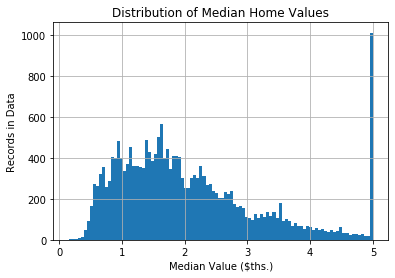

In [129]:
df.MedHouseVal.hist(bins=100)
plt.title('Distribution of Median Home Values')
plt.xlabel('Median Value ($ths.)')
plt.ylabel('Records in Data')
plt.show()

Observations:
- Data is truncated at 500,000; which will cause issues in our analysis.  
- Bulk of the data centered between 100,000 - 300,000 dollars.

In [130]:
np.where(df.MedHouseVal >= 5, 1, 0).mean()

0.04806201550387597

- Removing those values would only reduce the dataset by 4.8%; probably something we'll want to do.

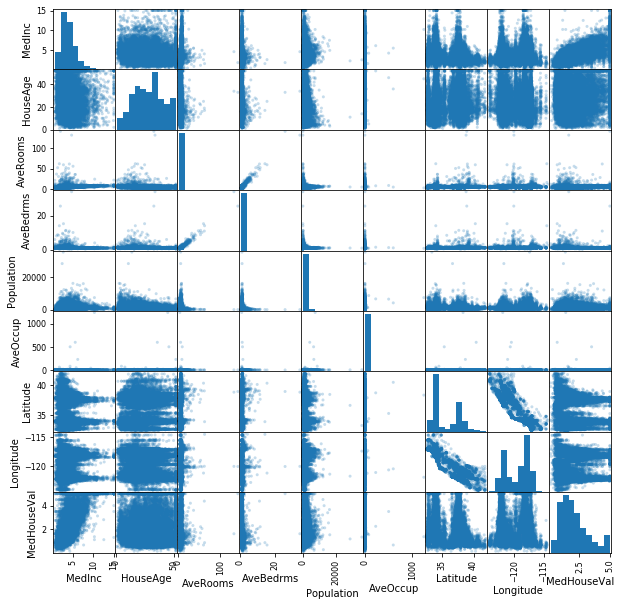

In [131]:
pd.plotting.scatter_matrix(df, figsize=(10,10), alpha=0.25)
plt.show()

- No apparent non-linear relationships.  
- Latitude and longtide are obviously related. May want to see how maps visualize this info.

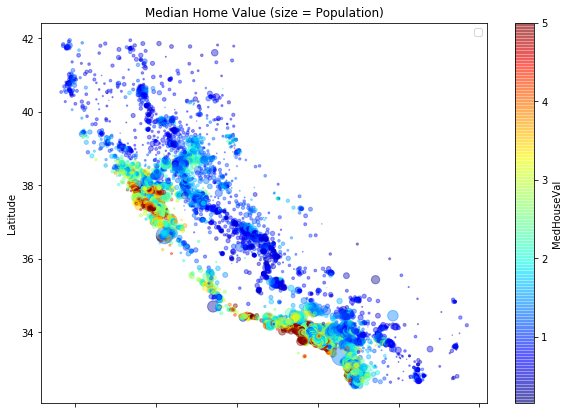

In [132]:
df.plot(kind='scatter', x='Longitude', y='Latitude', alpha=0.4, s=df['Population']/100,
            label='Population', figsize=(10,7), c='MedHouseVal', cmap=plt.get_cmap('jet'),
            colorbar=True)
plt.legend('')
plt.title('Median Home Value (size = Population)')
plt.show()

- High values concentrated on the coast, may want to create a variable that captures that.

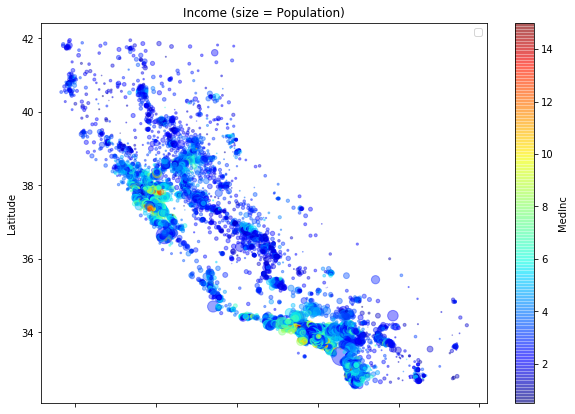

In [133]:
df.plot(kind='scatter', x='Longitude', y='Latitude', alpha=0.4, s=df['Population']/100,
            label='Population', figsize=(10,7), c='MedInc', cmap=plt.get_cmap('jet'),
            colorbar=True)
plt.legend('')
plt.title('Income (size = Population)')
plt.show()

- Income doesn't show the coastal trend as pronounced as home values.  
- Suggests affordability is going to vary significantly.

### Let's create a variable that captures or proxies the distance to the coast.

In [134]:
df['LatitudeRound'] = df.Latitude.round(1)

minLong = df.groupby('LatitudeRound')['Longitude'].min()
minLong = pd.DataFrame(minLong)
minLong = minLong.reset_index()
minLong = minLong.rename(columns={'Longitude':'coastLongitude'})
minLong.head()

,LatitudeRound,coastLongitude
0,32.5,-117.04
1,32.6,-117.17
2,32.7,-117.28
3,32.8,-117.31
4,32.9,-117.29


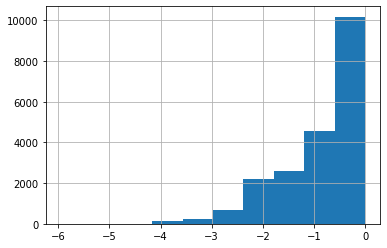

In [135]:
df2 = pd.merge(df, minLong, how='left', left_on='LatitudeRound', right_on='LatitudeRound')
df2['coastDist'] = df2['coastLongitude'] - df2['Longitude']

df2['coastDist'].hist()
plt.show()

Check to make sure we did the calculation correctly:

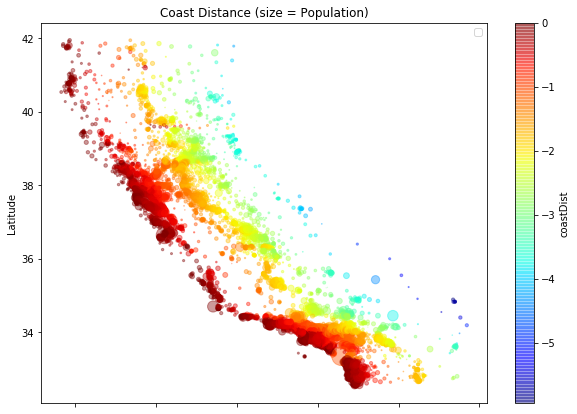

In [136]:
df2.plot(kind='scatter', x='Longitude', y='Latitude', alpha=0.4, s=df['Population']/100,
            label='Population', figsize=(10,7), c='coastDist', cmap=plt.get_cmap('jet'),
            colorbar=True)
plt.legend('')
plt.title('Coast Distance (size = Population)')
plt.show()

- Looks good, all concentration on the coast.  
- We bucketed the latitudes to protect against missing values in specific Latitude coordinates causing data to appear closer to the coast then it actual is.  
- We'll add this to the feature dataset as well.

In [137]:
coastDist = np.array(df2['coastDist']).reshape(-1,1)

X = np.concatenate([X, coastDist], axis=1)
X.shape

(20640, 9)

### Determine Drivers Using statsmodels

In [138]:
df2.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,LatitudeRound,coastLongitude,coastDist
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,37.9,-122.71,-0.48
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,37.9,-122.71,-0.49
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,37.8,-122.62,-0.38
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,37.8,-122.62,-0.37
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,37.8,-122.62,-0.37


#### Drop unnecessary variables and add the constant

In [139]:
df2 = df2.drop(columns=['Latitude','Longitude', 'LatitudeRound', 'coastLongitude'])
df2['const'] = 1
df2.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,MedHouseVal,coastDist,const
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,4.526,-0.48,1
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,3.585,-0.49,1
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,3.521,-0.38,1
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,3.413,-0.37,1
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,3.422,-0.37,1


# Linear regression on full dataset

In [140]:
import statsmodels.api as smf

featureNames = [x for x in df2.columns if x != 'MedHouseVal']

olsModel = smf.OLS(df2['MedHouseVal'], df2[featureNames]).fit()
print(olsModel.summary())

                            OLS Regression Results                            
Dep. Variable:            MedHouseVal   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     4347.
Date:                Mon, 04 Oct 2021   Prob (F-statistic):               0.00
Time:                        16:17:35   Log-Likelihood:                -22890.
No. Observations:               20640   AIC:                         4.580e+04
Df Residuals:                   20632   BIC:                         4.586e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
MedInc         0.4503      0.004    107.495      0.0

Observations:
- Overall $R^2$ is about 0.6; so the model is capturing 60% of the variance in median home values.  
- Everything except `Population` seemed statistically significant.  
- `Median Income` and our `Distance to Coast` measure seem to be the strongest drivers because of their high t-statistics.

#### Evaluate residuals

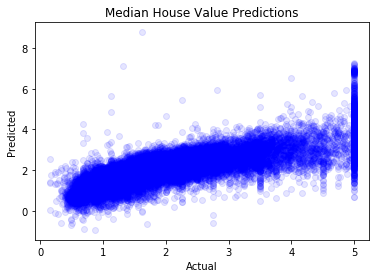

In [141]:
yhat = olsModel.predict(df2[featureNames])

plt.plot(df2['MedHouseVal'], yhat, 'bo', alpha=0.1)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Median House Value Predictions')
plt.show()

> As expected the truncated values at the end are probably going to cause odd residual behavior.

#### See if censoring those truncated values change any of the coefficients

In [142]:
import statsmodels.api as smf

df3 = df2.query('MedHouseVal<5')
featureNames = [x for x in df3.columns if x != 'MedHouseVal']

olsModel = smf.OLS(df3['MedHouseVal'], df3[featureNames]).fit()
print(olsModel.summary())

                            OLS Regression Results                            
Dep. Variable:            MedHouseVal   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     3598.
Date:                Mon, 04 Oct 2021   Prob (F-statistic):               0.00
Time:                        16:17:35   Log-Likelihood:                -19195.
No. Observations:               19648   AIC:                         3.841e+04
Df Residuals:                   19640   BIC:                         3.847e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
MedInc         0.4459      0.005     97.037      0.0

- $R^2$ is about the same, at 0.56. 
- Population is now significant, though not as overwhelming as the other features.  
- `Median Income` and `Distance to Coast` remain the strongest drivers.  
- Interesting that `Average Rooms` decreases the value, while `Average Bedrooms` increases.  
- That could be related to `Average Occupants` also being a negative driver. Which could be correlated to lower incomes.  

#### Evaluate Residuals

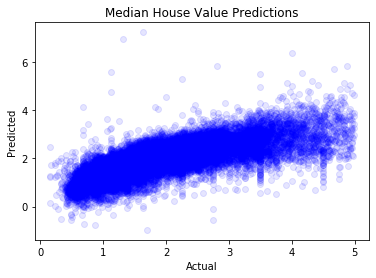

In [143]:
yhat = olsModel.predict(df3[featureNames])

plt.plot(df3['MedHouseVal'], yhat, 'bo', alpha=0.1)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Median House Value Predictions')
plt.show()

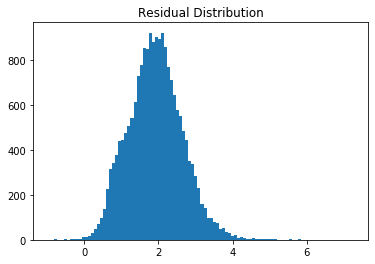

In [144]:
plt.hist(yhat, bins=100)
plt.title('Residual Distribution')
plt.show()

> Looks like a near-normal distribution. No obvious concerns with the residuals.

### Takeways from the Inference-based Regression Model

- After removing the truncated home values, all features are significant and the model explains about 60% of the overall variance.    
- Some are counter-intuitive (e.g., `Average Rooms` is a negative effect). That could be explained by hidden features of the dataset. Since this is an aggregated dataset, there could be a mixture of several distributions that clouds the true relationship.  
- There could also be issues with multicollinearity. There wasn't obvious issues from the scatterplots, but could be resident after controlling for certain features.  
- We do admit this regression is somewhat flawed because all of samples aren't independent. Nearby blocks will be more related to each other than blocks further away.

# How well can we predict the housing values?
First we need to split our data into a training and test set.

In [145]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)

print(f'Training examples: {X_train.shape[0]:,}')
print(f'Test examples: {X_test.shape[0]:,}')

Training examples: 16,512
Test examples: 4,128


#### Now we need to create a pipeline to preprocess the data and fit the model.
- Since we have all numerical features, with no missing values, we just need a scaler.

In [146]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

modeling_pipeline = Pipeline([('data_processing', StandardScaler()), ('lm', LinearRegression())])
modeling_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_processing', StandardScaler()),
                ('lm', LinearRegression())])

#### And now we can evaluate the model on the test data

In [147]:
modeling_pipeline.score(X_train, y_train)

0.6035688634368794

In [148]:
modeling_pipeline.score(X_test, y_test)

0.6231734031226607

> $R^2$ on training and test data are both about 60%. No strong evidence of overfitting

#### We can use Ridge to see if adding regularization improves the fit

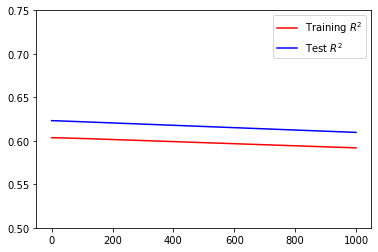

In [149]:
from sklearn.linear_model import Ridge
alphas = [0.01, 0.1, 1, 10, 100, 1000]

training_scores = []
test_scores = []
for alpha in alphas:
    modeling_pipeline = Pipeline([('data_processing', StandardScaler()), ('lm', Ridge(alpha=alpha))])
    modeling_pipeline.fit(X_train, y_train)
    training_scores.append(modeling_pipeline.score(X_train, y_train))
    test_scores.append(modeling_pipeline.score(X_test, y_test))
    
plt.plot(alphas, training_scores, 'r-')
plt.plot(alphas, test_scores, 'b-')
plt.ylim((0.5,0.75))
plt.legend(['Training $R^2$', 'Test $R^2$'])
plt.show()

> Ridge doesn't seem to change the model for the better. We'll conclude an OLS is fine by itself.

# Conclusions

- We were about to explain about 60% of the variance in `Median Home Value` in our standard regression model and observed about the same level of predictive performance.  
- The data has truncation issues, so it reasonable to potentially exclude those values. It doesn't seem to effect the model's performance though.  
- In terms of drivers, we noticed the `Median Income` and `Distance to Coast` were the strongest influencers in our regression model.  
- There could be complicated multicollinearity issues that are masked because the data is aggregated that could be pursued further.  
- It would be interesting to explore getting additional data and potentially adding features engineered from nearby locales.  